## Model Training

In [1]:
# import libraries for deep learning tasks
import tensorflow as tf 
from tensorflow.keras import layers, models 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import libraries for data processing and visualisation tasks
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# import tools for model development tasks
from model_training_tools import data_preprocessing

# import dataset from image processing
from MobilePhoneDataset import MobileImageDataset

Approach: 
+ Data Preparation
+ Building input Pipeline
+ Model Selection
+ Model Training


## Data Loading and Preparing

In [2]:
from sklearn.preprocessing import OneHotEncoder

+ Loading image data from MobileImageDataset-class
+ Resize the dataset and convert into tensors
+ Convert labels into numerical values using one-hot-encoding 
+ Create DataLoaders
+ Visualise Dataset

In [3]:
# Define mobile phone dataset
csv_file = "dataset.csv"
img_source_dir = "D:\Machine_Learning\Portfolio_Project_Machine_Learning\Mobile_Phone_Recognition\datasets\img_collection1"
mobile_data = MobileImageDataset(csv_file=csv_file, data_dir=img_source_dir)
mobile_df = mobile_data.data_name.drop(columns="Unnamed: 0", axis=1)
mobile_df

,Company,Image_file
0,Samsung,image_000.jpg
1,Samsung,image_001.jpg
2,Motorola,image_002.jpg
3,Xiaomi,image_003.jpg
4,Samsung,image_004.jpg
...,...,...
795,Nokia,image_795.jpg
796,Samsung,image_796.jpg
797,Nokia,image_797.jpg
798,Xiaomi,image_798.jpg


In [4]:
# Convert company labels to numerical data
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).set_output(transform='pandas')
company_ohe = ohe.fit_transform(mobile_df[["Company"]])
company_ohe.columns = [column.replace("Company_", "") for column in company_ohe.columns]
mobile_df = pd.concat([mobile_df, company_ohe], axis=1)
mobile_df.head()

,Company,Image_file,Apple,Microsoft,Motorola,Nokia,OnePlus,Poco,Redmi,Samsung,Xiaomi
0,Samsung,image_000.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Samsung,image_001.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Motorola,image_002.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Xiaomi,image_003.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Samsung,image_004.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Dataset (Size): 800


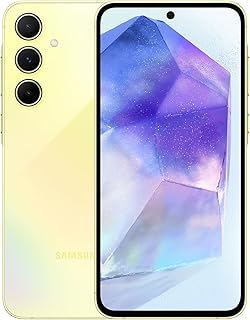

In [5]:
print(f"Dataset (Size): {mobile_data.len}")
mobile_data[1][0]

In [6]:
# Remove microsoft from dataset
mobile_df = mobile_df[mobile_df["Company"] != "Microsoft"] # at 379
mobile_df.index = [i for i in range(mobile_df.shape[0])]

# Create a dataframe with mobile phone images and its labels 
img_files = mobile_df["Image_file"]
class_names = mobile_df["Company"]

mp_data_registry = {
  "Image_paths": [os.path.join(img_source_dir, img_files.loc[idx]) for idx in range(mobile_df.shape[0])],
  "Class_names": [ class_names.loc[idx] for idx in range(mobile_df.shape[0])]
}

print(f"Image Path list: {mp_data_registry['Image_paths'][:2]}")
print(f"Class_names name list: {mp_data_registry["Class_names"][:2]}")

img_path_ds = pd.DataFrame(mp_data_registry)
img_path_ds.head()
print(f"Image Path Dataset(Size): {img_path_ds.shape}")

Image Path list: ['D:\\Machine_Learning\\Portfolio_Project_Machine_Learning\\Mobile_Phone_Recognition\\datasets\\collections\\source_images\\image_000.jpg', 'D:\\Machine_Learning\\Portfolio_Project_Machine_Learning\\Mobile_Phone_Recognition\\datasets\\collections\\source_images\\image_001.jpg']
Class_names name list: ['Samsung', 'Samsung']
Image Path Dataset(Size): (799, 2)


In [7]:
# Constants for resizing the images  
image_size = (330,330)
batch_size = 64

# loading and preprocessing image data
train_generator, test_generator = data_preprocessing(dataframe=img_path_ds, 
                                                     train_size=0.8,
                                                    img_size=image_size,
                                                    batch_size=batch_size,
                                                    rotation=30)


Found 639 validated image filenames belonging to 8 classes.
Found 160 validated image filenames belonging to 8 classes.
Shape of train images: (330, 330, 3)
Number of training samples: 639
Number of test samples: 160


In [8]:
# apply data augmentation on mobile phone images
# inspect the images with different degrees
def image_inspection(update_degrees: int, update_img_size: tuple, update_batch_size: int): 
  # re-augment the train and test images
  train_generator, test_generator = data_preprocessing(dataframe=img_path_ds,
                                                       train_size=0.8,
                                                    img_size=update_img_size,
                                                    batch_size=update_batch_size,
                                                    rotation=update_degrees)
  # get the images and labels 
  images, labels = next(train_generator)

  # get class indices from one-hot encoded labels
  class_indices = train_generator.class_indices
  class_names = {v:k for k, v in class_indices.items()}

  # convert one-hot labels to class indices
  label_indices = labels.argmax(axis=1)

  # plot a few examples
  plt.figure(figsize=(10, 10))
  for i in range(16):
    plt.subplot(4,4, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[label_indices[i]])
    plt.axis('off')
  plt.show()

  return images, labels

In [9]:
# test case: image size and degrees for image rotation
rotations = [30, 20, 15, 10]
img_sizes = [(128, 128),(256, 256),(300,300),(315,315), (330,330)]

Found 639 validated image filenames belonging to 8 classes.


Found 160 validated image filenames belonging to 8 classes.
Shape of train images: (330, 330, 3)
Number of training samples: 639
Number of test samples: 160


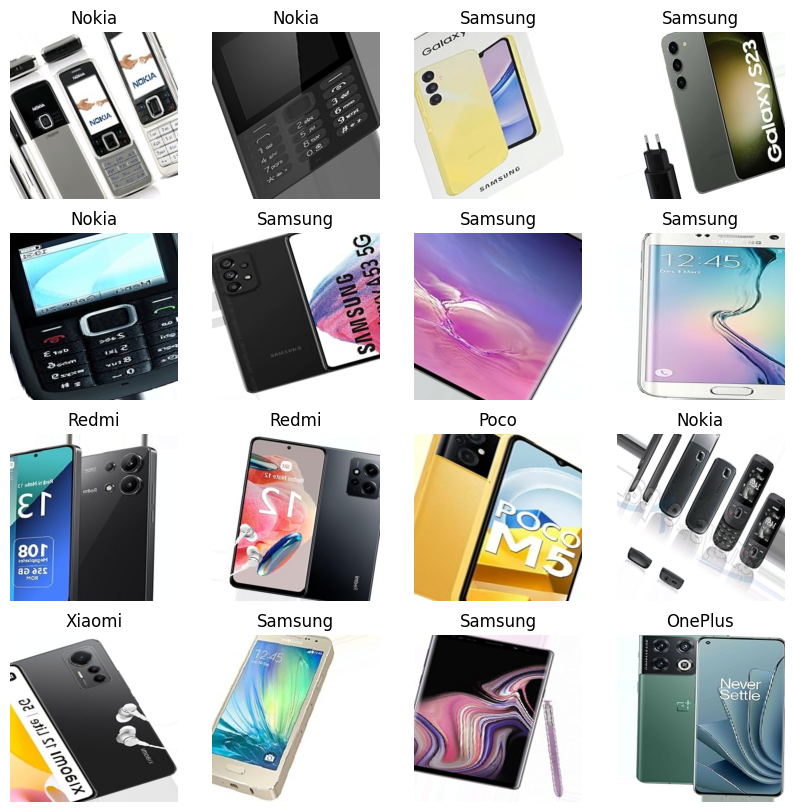

In [10]:
# inspect images with different rotation degrees
# image_inspection(degrees=20) # 20 degrees
images, labels = image_inspection(update_degrees=30, update_img_size=img_sizes[-1], update_batch_size=batch_size) # 30 degrees

## Model Development: ConvNeuralNet (Model 1)

In [11]:
from model_selection import ConvNeuralNet

Approach: Model Training

+ Model Building: 2 models
+ Model Selection
+ Tran the model with Testing and Training data

## Model Building

In [12]:
# Build 2 models for training
img_input_shape = (330, 330, 3)
# model1 = CNNModel(num_inputs=639, num_classes=8, rate=0.4)
model1 = ConvNeuralNet(input_shape=img_input_shape, brand_names=8, rate=0.4)
# model2 = convolutiona_nn_model(input_shape=(330, 330, 3), brand_names=8, rate=0.4)

# Compile the model 
model1.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=["accuracy"])

# Summary
model1.build(input_shape=(batch_size, 330, 330, 3))
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 330, 330, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 328, 328, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 164, 164, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 162, 162, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 81, 81, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 79, 79, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 48672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,230,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,269,032 (23.91 MB)

 Trainable params: 6,269,032 (23.91 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [14]:
from model_training_tools import model_training

In [15]:
# Train the model
model_hist1 = model1.fit(
  train_generator,
  epochs=10,
  batch_size=64, 
  validation_data=test_generator
)

d:\Machine_Learning\Portfolio_Project_Machine_Learning\Mobile_Phone_Recognition\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - accuracy: 0.3131 - loss: 2.9926 - val_accuracy: 0.4000 - val_loss: 1.6374
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.4397 - loss: 1.5774 - val_accuracy: 0.3812 - val_loss: 1.6050
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.4552 - loss: 1.4993 - val_accuracy: 0.4375 - val_loss: 1.5694
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.5139 - loss: 1.4501 - val_accuracy: 0.4750 - val_loss: 1.4985
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.4828 - loss: 1.4428 - val_accuracy: 0.5000 - val_loss: 1.3850
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.4845 - loss: 1.4538 - val_accuracy: 0.4875 - val_loss: 1.5915
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.4942 - loss: 1.3581 - val_accuracy: 0.5250 - val_loss: 1.3629
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.5136 - loss: 1.2912 - val_accuracy: 0.5500 - val_loss:

In [31]:
# store the performance metrics into dataset
perform_metrics = model_hist1.history
perfm_df = pd.DataFrame(perform_metrics)
perfm_df.to_csv("performance_data/perform_dataset.csv")
perfm_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.302034,1.927714,0.38750,1.665595
1,0.416275,1.594595,0.41250,1.628890
2,0.456964,1.511192,0.43125,1.498880
3,0.475743,1.452840,0.48750,1.462907
4,0.489828,1.410027,0.50625,1.392137


## Model Packaging

In [33]:
from tensorflow.keras.models import load_model

+ Save the model after training
+ Load one random mobile image for predicting the model
+ Predict the image with the model

Check later: save_model()

In [34]:
# save the model image
def save_model(model, model_name, input_path): 
  # define the constants: save a model
  model_file = f"mobile_recon_{model_name}.keras"
  model_path = os.path.join(input_path, model_file)
  
  # verify model successfully saved
  if os.path.exists(input_path):
    model.save(model_path)
    print("Model saved successfully!")
    print(f"Location: {model_path}")
  else:
      print("Model saving failed. Check the path.")
      print(f"Path: {model_path}")

In [35]:
path = "D:\\Machine_Learning\\Portfolio_Project_Machine_Learning\\Mobile_Phone_Recognition\\models"
save_model(model=model1, 
           model_name="model1",
           input_path=path)

Model saved successfully!
Location: D:\Machine_Learning\Portfolio_Project_Machine_Learning\Mobile_Phone_Recognition\models\mobile_recon_model1.keras
